In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob as tb
from autocorrect import Speller as sp
import emoji
import nltk
from nltk.tokenize import word_tokenize as wt,sent_tokenize as st
from nltk.corpus import stopwords
from nltk import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as ss
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,classification_report,\
roc_auc_score,roc_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

# 1.Problem Statement

Create a model to classify the Quality of a fruit based on their features

# 2. Data Collection or Data Gathering

collect the dataset from kaggle,which is used to create a good model for classification

In [2]:
data=pd.read_csv(r"C:\Users\pavan\Desktop\satya\Machine learning\Projects\apple_quality.csv") # importing the data

In [3]:
df=data.copy()   # copying the original data into duplicate data

In [4]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


# 3.EDA_1

In [5]:
df.info()           # checking the information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [6]:
df.isnull().sum()                                 # Checking Null values in dataset

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

In [7]:
df.duplicated().sum()                                     # Checking for duplicate values in the dataset

0

In [8]:
df['Quality'].value_counts()                              # Checking how the data is either balanced or imbalanced

good    2004
bad     1996
Name: Quality, dtype: int64

In [9]:
df.drop(4000,axis = 0,inplace = True)   # remove missing row,which contain last row in the data set.

In [10]:
df["Acidity"] = df["Acidity"].astype("float")   # we can convert Acidity type from object to numerical

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 281.4+ KB


In [12]:
df.describe()                                 # Checking all the statstical values of numrical columns in the dataset

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


# 4.Data Pre-Processing

In [13]:
fv=df.iloc[:,1:8]
cv=df.iloc[:,-1]

In [14]:
fv.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984


In [15]:
cv.head()

0    good
1    good
2     bad
3    good
4    good
Name: Quality, dtype: object

In [16]:
cv=cv.map({"good":1,"bad":0})

In [17]:
cv.head()

0    1
1    1
2    0
3    1
4    1
Name: Quality, dtype: int64

# 5.EDA_2

In [18]:
# find the relation between features
# Correlation matrix
corr_matrix = fv.corr()
corr_matrix

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,1.000000,-0.170702,-0.324680,0.169868,-0.018892,-0.134773,0.196218
Weight,-0.170702,1.000000,-0.154246,-0.095882,-0.092263,-0.243824,0.016414
Sweetness,-0.324680,-0.154246,1.000000,-0.037552,0.095882,-0.273800,0.085999
Crunchiness,0.169868,-0.095882,-0.037552,1.000000,-0.259607,-0.201982,0.069943
Juiciness,-0.018892,-0.092263,0.095882,-0.259607,1.000000,-0.097144,0.248714
Ripeness,-0.134773,-0.243824,-0.273800,-0.201982,-0.097144,1.000000,-0.202669
Acidity,0.196218,0.016414,0.085999,0.069943,0.248714,-0.202669,1.000000


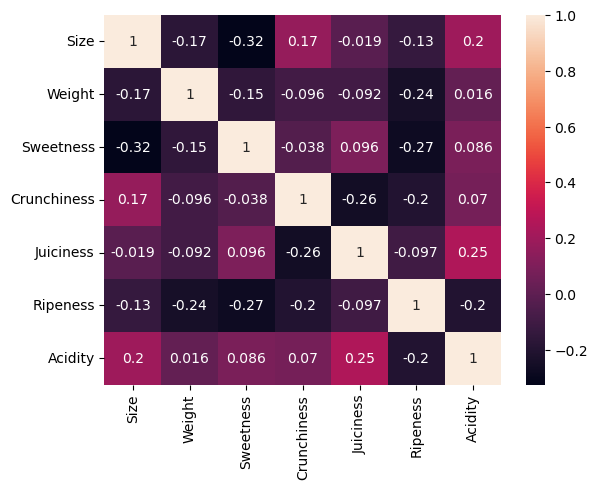

In [19]:
sns.heatmap(corr_matrix, annot=True)
plt.show()                                          # Checking for co-relation between any column

Based on above graph and table, all the features are independent only.So we will go with Naive Bayes theroem

our dataset is a numerical data set so we will go with Gaussian distribution.


then check each feature follows gaussian distribution or not

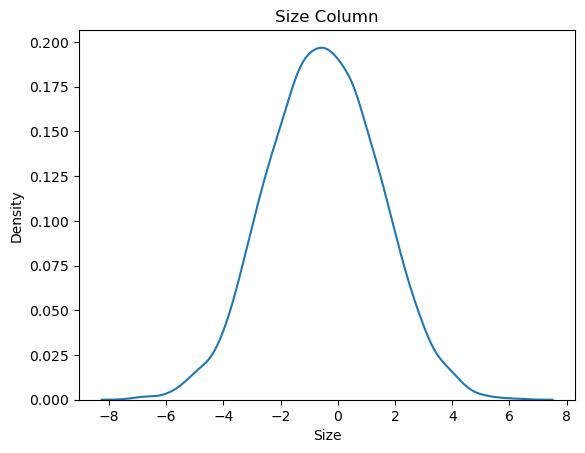

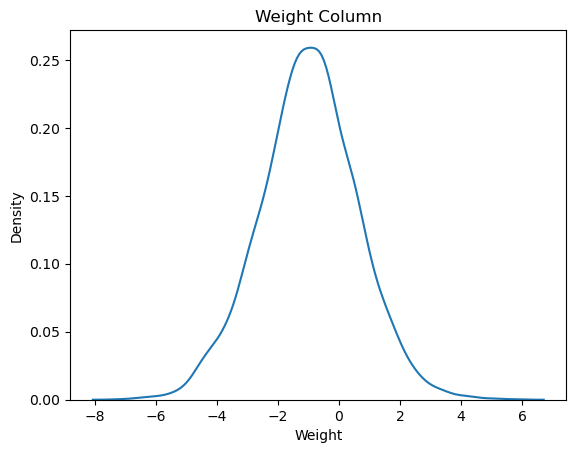

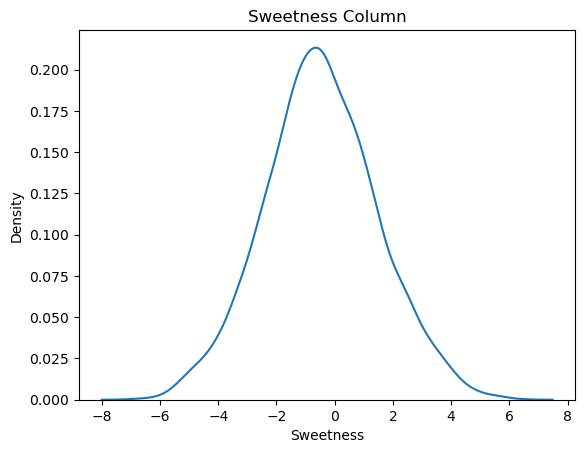

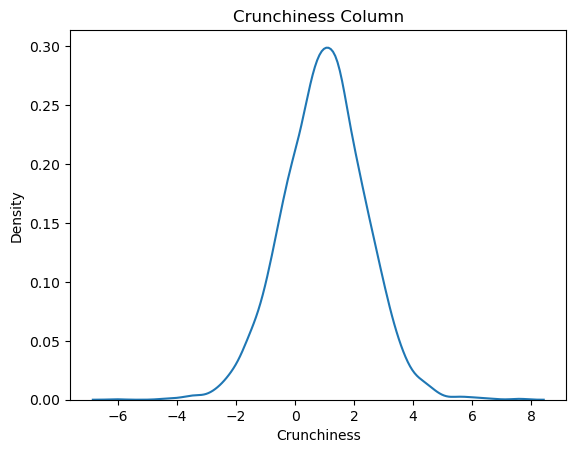

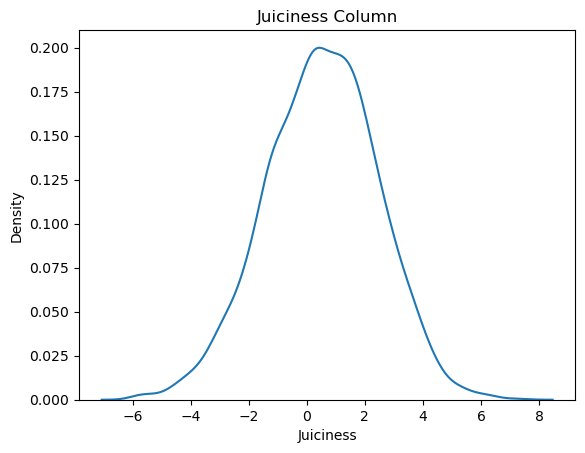

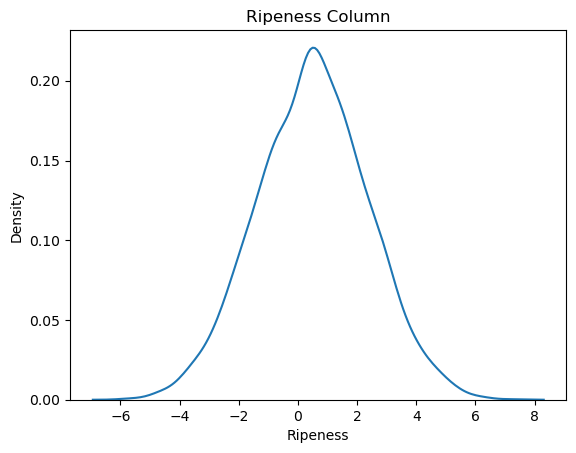

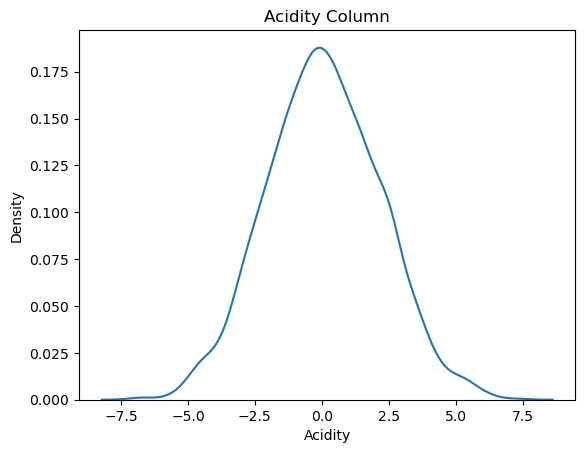

In [20]:
for i in fv.columns:
    sns.kdeplot(fv[i])
    plt.title(i+' Column')
    plt.show()                  # Distributions of each column

# Q-Q plot

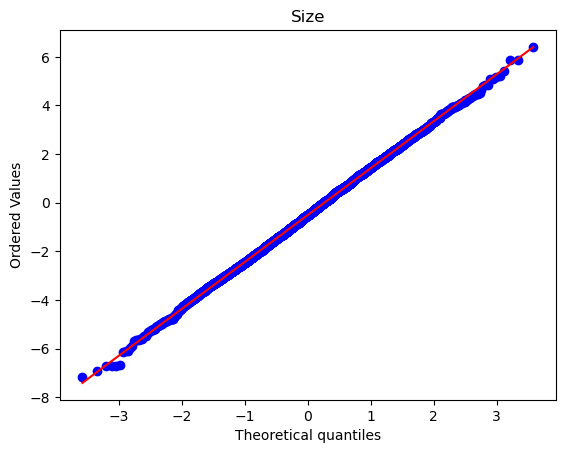

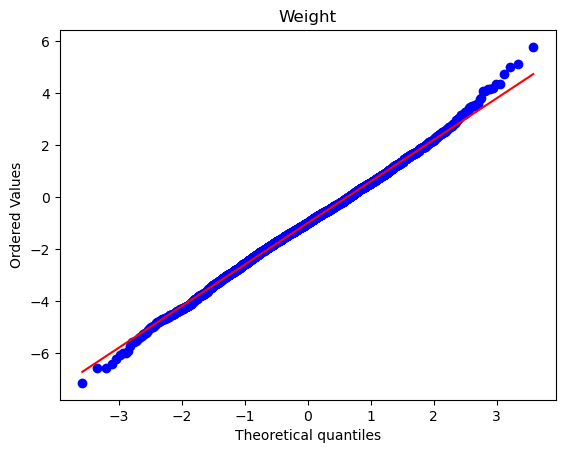

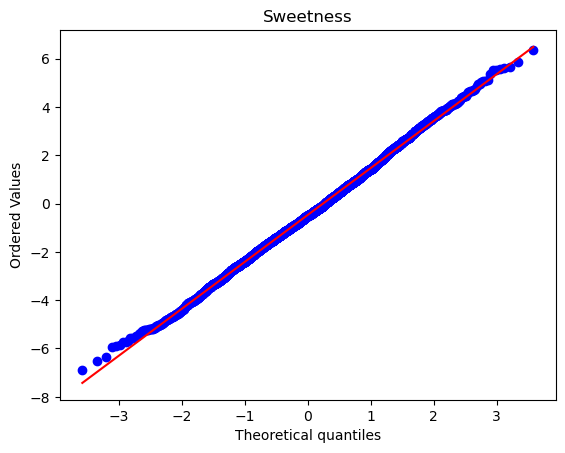

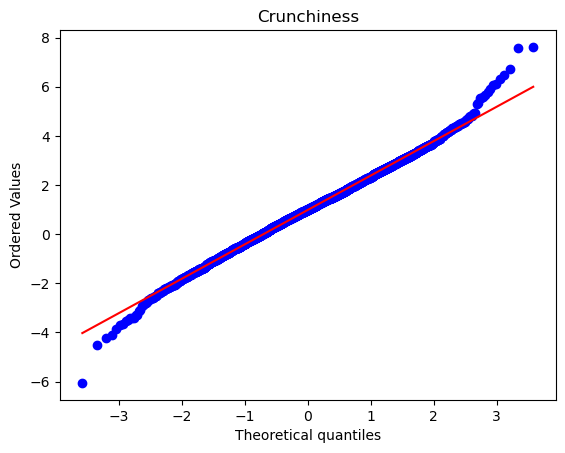

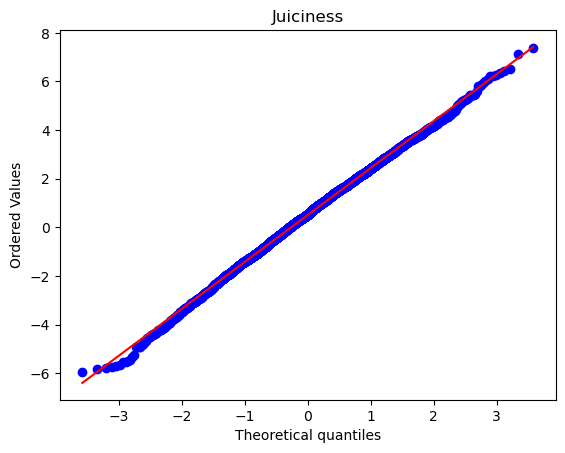

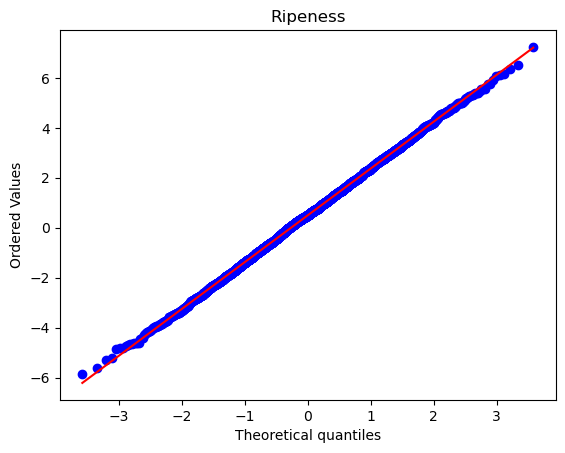

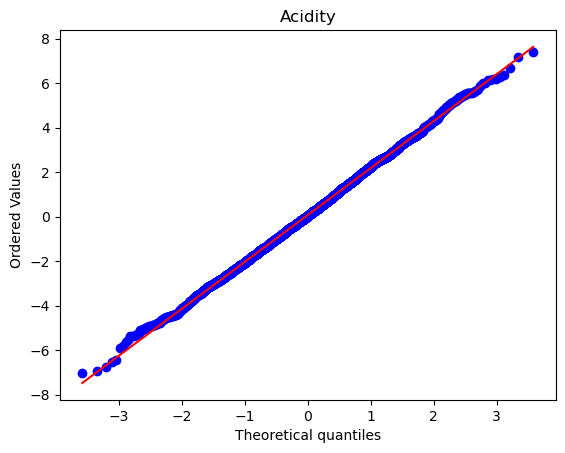

In [21]:
for y in fv.columns:
    ss.probplot(fv[y],dist="norm",fit=True,plot=plt)
    plt.title(y)
    plt.show()

Based on above graphs, all the features follows Gaussian distribution,So we performe Gaussian Naive bayes

# 6. Feature Extraction or Feature Engineering

In [22]:
# Spliting the data into parts as Training and Testing
x_train,x_test,y_train,y_test=train_test_split(fv,cv,test_size=0.2,random_state=3,stratify=cv)

In [23]:
x_train.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
12,-0.170812,-1.867271,-1.771845,2.413155,-3.094555,-0.624884,-2.076114
2763,-0.530637,-0.556666,1.057852,-0.442602,-1.852590,-1.650415,-0.733236
1463,1.046011,-3.744529,-4.502815,5.663943,1.673697,-1.039944,-0.607660
3648,-0.721063,-0.848216,-0.706661,0.802176,-0.381320,-0.545140,2.069510
1831,-0.956354,0.990504,-2.189060,0.758420,-0.612463,0.660522,0.119976


In [24]:
y_train.head()

12      0
2763    1
1463    1
3648    0
1831    0
Name: Quality, dtype: int64

In [25]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 12 to 3961
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         3200 non-null   float64
 1   Weight       3200 non-null   float64
 2   Sweetness    3200 non-null   float64
 3   Crunchiness  3200 non-null   float64
 4   Juiciness    3200 non-null   float64
 5   Ripeness     3200 non-null   float64
 6   Acidity      3200 non-null   float64
dtypes: float64(7)
memory usage: 200.0 KB


In [26]:
numerical_data=x_train.select_dtypes(include=["int64","float64"])

In [27]:
numerical_data.columns

Index(['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness',
       'Acidity'],
      dtype='object')

In [28]:
num_pip=Pipeline([("Imputer",SimpleImputer()),("standardization",StandardScaler())])

In [29]:
 # for categorical column
#cp=Pipeline([("impu_c",SimpleImputer(strategy="most_frequent")),("Encoding",OneHotEncoder())])

In [30]:
ctp = ColumnTransformer([("numerical",num_pip,numerical_data.columns)],remainder = "passthrough")

In [31]:
ctp

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('Imputer', SimpleImputer()),
                                                 ('standardization',
                                                  StandardScaler())]),
                                 Index(['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness',
       'Acidity'],
      dtype='object'))])

In [32]:
pd.DataFrame(ctp.fit_transform(x_train),columns=x_train.columns)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,0.173411,-0.546887,-0.670003,1.018915,-1.855837,-0.598166,-1.034458
1,-0.012750,0.276547,0.787496,-1.018371,-1.214507,-1.141605,-0.398403
2,0.802950,-1.726340,-2.076650,3.338013,0.606408,-0.818110,-0.338924
3,-0.111269,0.093370,-0.121357,-0.130351,-0.454768,-0.555909,0.929119
4,-0.233000,1.248611,-0.884899,-0.161567,-0.574126,0.082983,0.005721
...,...,...,...,...,...,...,...
3195,-0.465769,-0.502747,-0.207427,0.127192,-0.365164,0.985730,0.142509
3196,1.704942,0.406318,-1.834249,-0.756822,0.833293,-0.205857,-0.739897
3197,-0.313966,0.530544,0.237814,0.257828,0.699550,-0.047928,-1.030866
3198,-1.445642,2.610392,-0.476965,-1.031918,0.877446,-0.923524,-1.746793


In [52]:
final_pre=Pipeline([("Pre-Processing",ctp)])

In [53]:
import pickle
pickle.dump(final_pre,open(r"C:\Users\pavan\Desktop\satya\Machine learning\streamlit\streamlit_14\apple_final_pre.pkl","wb"))

# 7. Training

In [54]:
# create an object of GaussianNB class
g = GaussianNB()

# fit x_train and y_train based on gaussian NB
model = g.fit(final_pre.fit_transform(x_train),y_train)

predicted_cls = model.predict(x_test)
accuracy_score(y_test, predicted_cls)*100

C:\Users\pavan\anaconda3\psk\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


72.0

In [55]:
import pickle
pickle.dump(model,open(r"C:\Users\pavan\Desktop\satya\Machine learning\streamlit\streamlit_14\apple_model.pkl","wb"))

# 8.Model Evaluation

In [34]:
precision_score(y_test, predicted_cls,pos_label=1)

0.7387173396674585

In [35]:
recall_score(y_test, predicted_cls)

0.7755610972568578

In [36]:
f1_score(y_test, predicted_cls)

0.75669099756691

In [37]:
cm=confusion_matrix(y_test, predicted_cls)

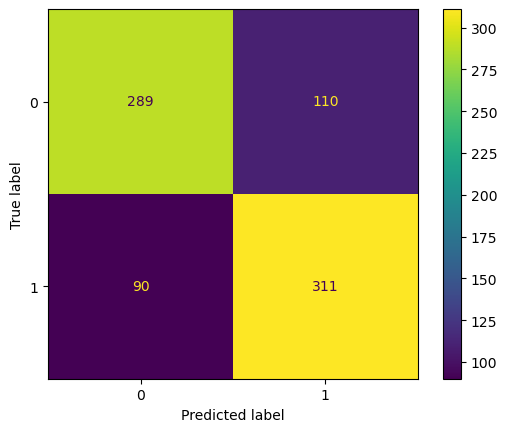

In [38]:
ConfusionMatrixDisplay(cm,display_labels=g.classes_).plot()
plt.show()

In [39]:
precision_score(y_test, predicted_cls, pos_label= 0)

0.762532981530343

In [40]:
precision_score(y_test, predicted_cls, pos_label= 1)

0.7387173396674585

In [41]:
recall_score(y_test, predicted_cls, pos_label= 0)

0.7243107769423559

In [42]:
recall_score(y_test, predicted_cls, pos_label= 1)

0.7755610972568578

In [43]:
f1_score(y_test, predicted_cls, pos_label= 0)

0.7429305912596401

In [44]:
f1_score(y_test, predicted_cls, pos_label= 1)

0.75669099756691

In [45]:
print(classification_report(y_test, predicted_cls))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       399
           1       0.74      0.78      0.76       401

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



In [46]:
model.predict_proba(x_test)    # gives probability of both class labels

array([[0.7621622 , 0.2378378 ],
       [0.0162905 , 0.9837095 ],
       [0.04345631, 0.95654369],
       ...,
       [0.76097349, 0.23902651],
       [0.60125413, 0.39874587],
       [0.82280495, 0.17719505]])

In [47]:
pl = model.predict_log_proba(x_test)[:,1]

In [48]:
pm = model.predict_proba(x_test)[:,1]  # pm contains probability of positive class only from x_test.

In [49]:
fpr,tpr,_ = roc_curve(y_test,pm)    # from roc_curve(y_test,pm) , i take  fpr , tpr values only then plot  . we can use binary class only

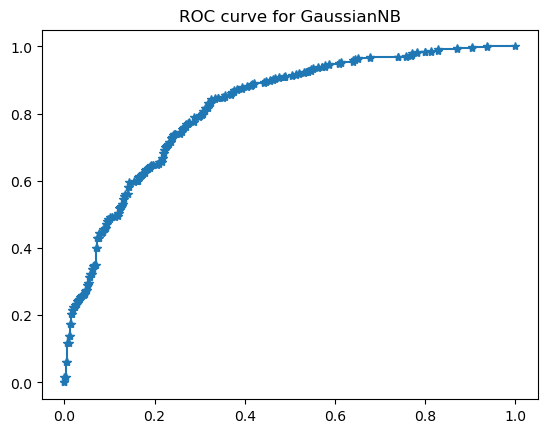

In [50]:
plt.plot(fpr,tpr,marker = "*")                  # we can use binary class only
plt.title("ROC curve for GaussianNB")
plt.show()

In [51]:
roc_auc_score(y_test,pm)   # roc_auc_score(y_test,pm) give area of under curve. It shows 82% so this is good model.

0.820773879836749